In [1]:
# ============================================================================
# STEP 1: ENVIRONMENT SETUP
# ============================================================================
# Load environment variables and initialize Google Earth Engine

from dotenv import load_dotenv
load_dotenv()

import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')

forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [2]:
# ============================================================================
# STEP 2: LOAD AREA OF INTEREST (AOI) but only on the AOI concession
# ============================================================================
# Load the area of interest geometry for reference

from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee('./00_input/korindo_buffer.shp')

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

✅ AOI loaded: 1 features
   Area: 40740.66 hectares


In [3]:
### ts fresh historical deforestation, and current forest, tsfresh
tsfresh_pred_result = forestry.config['tsfresh_pred_result']
lc_pred_result = forestry.config['lc_pred_result']


ds_tsfresh = load_dataset_zarr(tsfresh_pred_result)
ds_lc = load_dataset_zarr(lc_pred_result)

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_results_tsfresh_aoi.zarr


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


✅ Dataset loaded: {'sample': 4073658, 'features': 197}
📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr
✅ Dataset loaded: {'sample': 4197230, 'feature': 30}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


In [4]:
from forestry_carbon_arr import plot_unstack_ds

## palette for tsfresh
palette_class_segment_tsfresh = {
    0: '#fc0303',   # not-eligible
    1: '#03fcb1'  # eligible
}

# Custom palette for land-cover classes (1..14)
palette_class_segment_landcover = {
    1: '#83ff5a',   # forest_trees (1)
    2: '#ffe3b3',   # shrubland (2)
    3: '#ffff33',   # grassland (3)
    4: '#f89696',   # openland (4)
    5: '#1900ff',   # waterbody_waterlogged (5)
    6: '#e6e6fa',   # plantation (6)
    7: '#FFFFFF',   # gray_infrastructure (7)
    8: '#4B0082',   # oil_palm (8)
    9: '#8B4513',   # cropland (9)
    10: '#87CEEB',  # waterbody (10)
    11: '#2F4F4F',  # wetlands (11)
    12: '#ADFF2F',  # forest_trees_regrowth (12)
    13: '#8B0000',  # historical_treeloss_10years (13)
    14: '#DAA520',  # paddy_irrigated (14),
}

# Derived mapping ready for plot_unstack_ds(cmap_custom=...)
cmap_custom_tsfresh = {cid: hexcolor for cid, hexcolor in palette_class_segment_tsfresh.items()}
print("cmap_custom defined for classes tsfresh:", sorted(cmap_custom_tsfresh.keys()))

cmap_custom_landcover = {cid: hexcolor for cid, hexcolor in palette_class_segment_landcover.items()}
print("cmap_custom defined for classes landcover:", sorted(cmap_custom_landcover.keys()))

cmap_custom defined for classes tsfresh: [0, 1]
cmap_custom defined for classes landcover: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [5]:
ds_tsfresh = ds_tsfresh.assign_attrs(
    crs=forestry.config['output_crs']
)

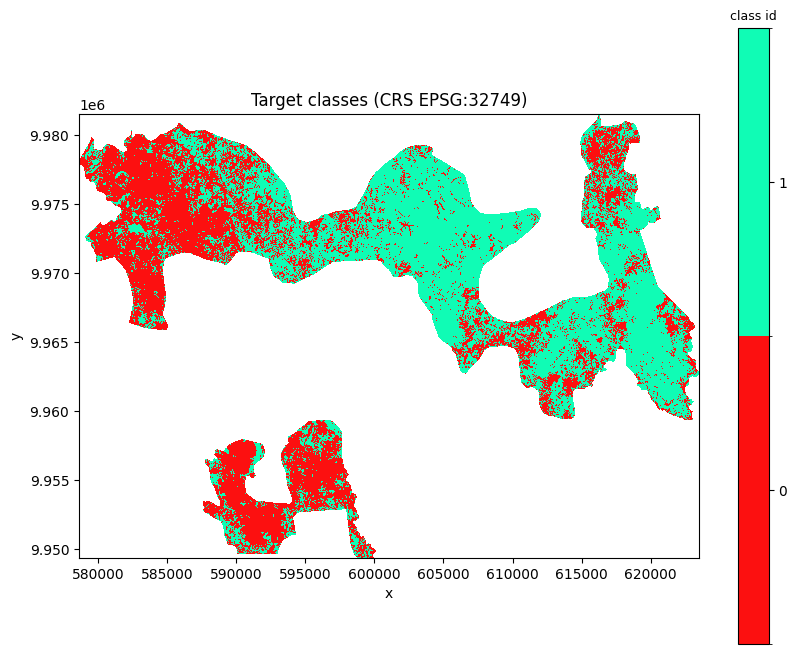

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Target classes (CRS EPSG:32749)'}, xlabel='x', ylabel='y'>)

In [6]:
plot_unstack_ds(ds_tsfresh,y=True,y_var='y_pred',cmap_custom=cmap_custom_tsfresh)

In [7]:
# ds_lc

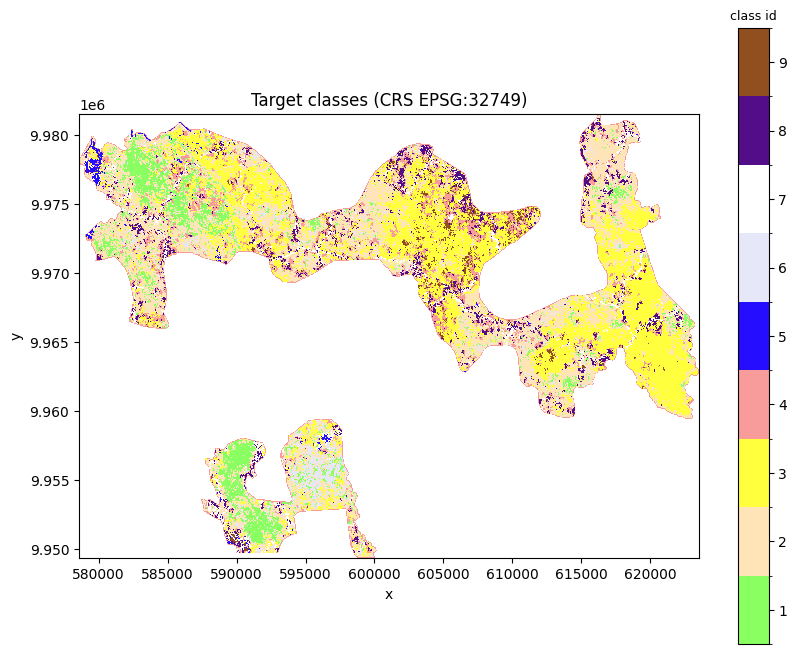

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Target classes (CRS EPSG:32749)'}, xlabel='x', ylabel='y'>)

In [8]:
plot_unstack_ds(ds_lc,y=True,y_var='pred_class',cmap_custom=cmap_custom_landcover)

In [9]:
## Re-read inference results - to re-check the results
from forestry_carbon_arr import load_model, save_config_ml, predict_dataset_features

# Load from local cache using config hash (optionally a timestamp)
# model, path, cfg = load_model(config=config, timestamp="20250101_120000")

model_tsfresh, path_tsfresh, cfg_tsfresh = load_model(
    gcs_model_path=forestry.config['cbm_tsfresh_path'],
    gcs_config_path=forestry.config['cbm_tsfresh_config'],
)

# Load model and config directly from GCS
model_lc, path_lc, cfg_lc = load_model(
    gcs_model_path=forestry.config['cbm_lc_path'],
    gcs_config_path=forestry.config['cbm_lc_config'],
)

# if we want to alter the config later
# class_label_map = {
#                 1: 'forest_trees',
#                 2: 'shrubland',
#                 3: 'grassland',
#                 4: 'openland',
#                 5: 'waterbody_waterlogged',
#                 6: 'plantation',
#                 7: 'gray_infrastructure',
#                 8: 'oil_palm',
#                 9: 'cropland',
#                 # 10:'waterbody',
#                 # 14: 'paddy_irrigated',
#             }

# # Prepare configuration with unique hash
# # Note: We're using class_weights (set above using optimal_weights) to handle class imbalance
# #       This is more effective than sample weights for this use case
# cfg_lc['label_map'] = class_label_map

# X_features_list = ds_lc.feature.values

# cfg_lc['X_features_list'] = list(X_features_list)

# cfg_tsfresh['X_features_list'] = list(ds_tsfresh.features.values)

# local_cfg_path = save_config_ml(
#     cfg_tsfresh,
#     gcs_path=forestry.config['cbm_tsfresh_config']  # optional upload
# )
# print("Saved config to:", local_cfg_path)

In [10]:
# ds_tsfresh
# cfg_tsfresh

In [11]:
# From the saved config
print("label_map:", cfg_lc.get("label_map"))

label_map: {'1': 'forest_trees', '2': 'shrubland', '3': 'grassland', '4': 'openland', '5': 'waterbody_waterlogged', '6': 'plantation', '7': 'gray_infrastructure', '8': 'oil_palm', '9': 'cropland'}


In [12]:
# len(cfg_lc.get("X_features_list"))

In [13]:
# cfg_lc


In [14]:
import importlib
import forestry_carbon_arr
import forestry_carbon_arr.ML.inference as fc_infer
import forestry_carbon_arr.ML.catboost_workflow as fc_cb
import forestry_carbon_arr.ML.vis as fc_vis

# Reload the top-level package (optional but helps refresh __all__)
importlib.reload(forestry_carbon_arr)

# Reload specific modules you’re using
importlib.reload(fc_infer)
importlib.reload(fc_cb)
importlib.reload(fc_vis)

# After reload, re-import the symbols you need
from forestry_carbon_arr import predict_dataset_features, load_model, save_config_ml, plot_unstack_ds

In [15]:
import importlib, forestry_carbon_arr.ML.inference as fc_infer
importlib.reload(fc_infer)
from forestry_carbon_arr import predict_dataset_features

# ds tsfresh test - re-run inference
ds_tsfresh_test = ds_tsfresh.drop_vars(['y_pred'])
ds_tsfresh_test = ds_tsfresh_test.rename({'features':'feature'})
# ds_tsfresh_test

preds, cx, cy = predict_dataset_features(
    model_tsfresh,
    ds_tsfresh_test,
    cfg_tsfresh,
    chunk_size=500_000,
)

Predicting:   0%|          | 0/9 [00:00<?, ?samples/s]

In [19]:
ds_tsfresh_test['y_pred'] =('sample', preds)
ds_tsfresh_test

# Optional: map numeric IDs to labels if label_map is present

<xarray.Dataset> Size: 7GB
Dimensions:            (sample: 4073658, feature: 197)
Coordinates:
  * feature            (feature) <U68 54kB 'EVI__fft_coefficient__attr_"angle...
  * sample             (sample) int64 33MB 0 1 2 3 ... 4073655 4073656 4073657
Data variables:
    coord_x            (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y            (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    eligibility_clean  (sample) int64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    plot_id            (sample) object 33MB dask.array<chunksize=(509208,), meta=np.ndarray>
    X_features         (sample, feature) float64 6GB dask.array<chunksize=(100000, 197), meta=np.ndarray>
    y_pred             (sample) int64 33MB 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
Attributes:
    crs:      EPSG:32749

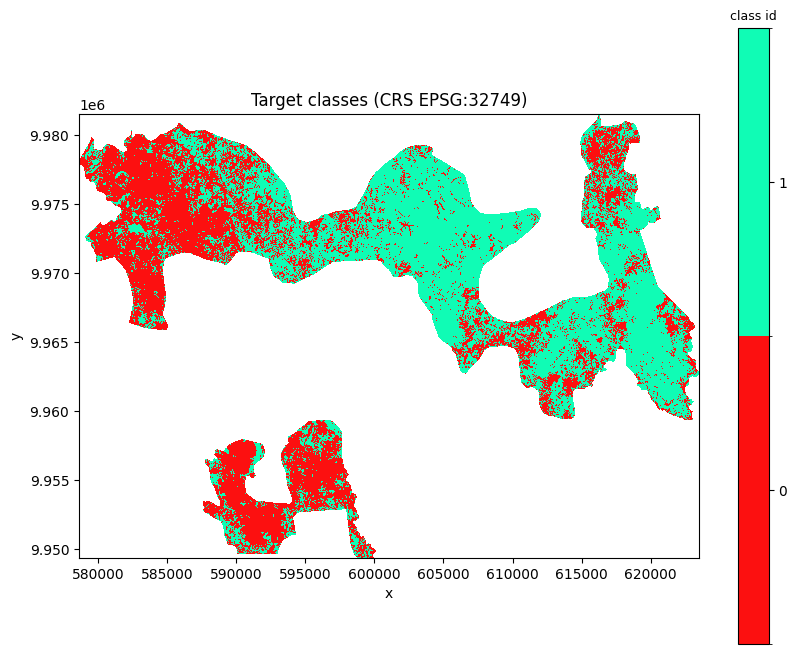

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Target classes (CRS EPSG:32749)'}, xlabel='x', ylabel='y'>)

In [20]:
plot_unstack_ds(ds_tsfresh_test,y=True,y_var='y_pred',cmap_custom=cmap_custom_tsfresh)

In [22]:
# ds_lc

In [ ]:
import importlib, forestry_carbon_arr, forestry_carbon_arr.ML.inference as fc_infer 
importlib.reload(fc_infer)          # reload the inference module
importlib.reload(forestry_carbon_arr)  # optional: reload package __init__
# from forestry_carbon_arr import predict_dataset_features


# ds tsfresh test - re-run inference
ds_lc_test = ds_lc.drop_vars(['pred_class'])
# ds_lc_test = ds_lc_test.rename({'features':'feature'})
# ds_lc_test

# preds_lc, cx_lc, cy_lc = predict_dataset_features(
preds_lc, cx_lc, cy_lc = fc_infer.predict_dataset_features(
    model_lc,
    ds_lc_test,
    cfg_lc,
    chunk_size=1000_000,
)

Predicting:   0%|          | 0/5 [00:00<?, ?samples/s]

In [ ]:
preds_lc
## flatten in np
# if preds_lc.ndim == 2 and preds_lc.shape[1] == 1:
#     pred_classes = preds_lc[:, 0]  # squeeze
# elif preds_lc.ndim == 2 and preds_lc.shape[1] > 1:
#     pred_classes = preds_lc.argmax(axis=1)  # if probs

# pred_classes

# or
# pred_classes = preds_lc.reshape(-1)

array([4., 4., 4., ..., 4., 4., 4.])

In [51]:
# ds_lc_test

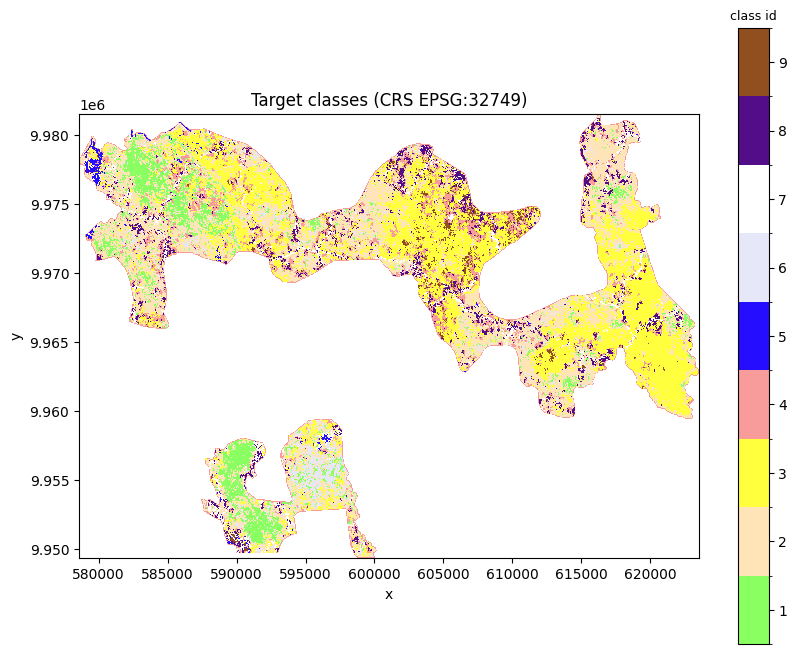

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Target classes (CRS EPSG:32749)'}, xlabel='x', ylabel='y'>)

In [52]:
ds_lc_test['pred_class'] =('sample', preds_lc)
plot_unstack_ds(ds_lc_test,y=True,y_var='pred_class',cmap_custom=cmap_custom_landcover)

In [ ]:
# Optional: map numeric IDs to labels if label_map is present
label_map = cfg.get("label_map", {}) if cfg else {}
pred_labels = [label_map.get(int(c), c) for c in y_pred]